In [1]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,RobustScaler
import seaborn as sns
import statsmodels.api as sm
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from statsmodels.stats.outliers_influence import variance_inflation_factor
import datetime


In [2]:
train = pd.read_csv("train_data-1599717478076.csv")
test = pd.read_csv("test_data-1599717650029.csv")
sol = pd.read_csv("Solution.csv")

In [3]:
test = pd.merge(left=test,right=sol,on="transaction_number",how="inner")

In [4]:
train["split"] = "train"
test["split"] = "test"

In [5]:
data = pd.concat([train,test])

In [6]:
data.head()

,transaction_number,user_id,payment_method,partner_id,partner_category,country,device_type,money_transacted,transaction_initiation,partner_pricing_category,is_fraud,split
0,144703125000,17539344,sbi_atm_cum_debit_card,47334,cat_1,IND_INR,android_devices,-5.0,2016-11-15 19:16:12+00:00,2,0,train
1,77406814453032,24710841,e_wallet_payments,78890,cat_2,IND_INR,other_pcs,100.0,2017-01-11 09:25:33+00:00,2,0,train
2,308929485482801,24265476,e_wallet_payments,78890,cat_2,IND_INR,other_pcs,50.0,2016-12-07 07:58:09+00:00,2,0,train
3,665270027747073,10240000,other_debit_cards,102557,cat_3,IND_INR,other_pcs,1000.0,2017-01-11 16:15:44+00:00,2,0,train
4,38276160171101,5880625,other_debit_cards,118335,cat_1,IND_INR,other_pcs,200.0,2016-11-16 17:04:42+00:00,2,0,train


In [7]:
data.nunique()

transaction_number          95662
user_id                      3742
payment_method                  6
partner_id                     23
partner_category                9
country                         1
device_type                     4
money_transacted             1676
transaction_initiation      94556
partner_pricing_category        4
is_fraud                        2
split                           2
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95662 entries, 0 to 19132
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   transaction_number        95662 non-null  int64  
 1   user_id                   95662 non-null  int64  
 2   payment_method            95662 non-null  object 
 3   partner_id                95662 non-null  int64  
 4   partner_category          95662 non-null  object 
 5   country                   95662 non-null  object 
 6   device_type               95662 non-null  object 
 7   money_transacted          95662 non-null  float64
 8   transaction_initiation    95662 non-null  object 
 9   partner_pricing_category  95662 non-null  int64  
 10  is_fraud                  95662 non-null  int64  
 11  split                     95662 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 9.5+ MB


In [9]:
data['transaction_initiation'] = pd.to_datetime(data.transaction_initiation)

In [10]:
data.sort_values(by=['transaction_initiation'],inplace=True)
data.reset_index(drop=True,inplace=True)

In [11]:
data['transaction_initiation_year'] = data['transaction_initiation'].dt.year
data['transaction_initiation_month'] = data['transaction_initiation'].dt.month
data['transaction_initiation_day'] = data['transaction_initiation'].dt.day
data['transaction_initiation_hour'] = data['transaction_initiation'].dt.hour
data['transaction_initiation_minute'] = data['transaction_initiation'].dt.minute
data['transaction_initiation_second'] = data['transaction_initiation'].dt.second

In [12]:
train_index = data[data.split=="train"].index
test_index = data[data.split=="test"].index

---

## Binning days,hours,minutes and seconds 

In [13]:
bin = [0,7,14,21,31]
day = pd.cut(data.transaction_initiation_day, bins = bin)

In [14]:
bin = [-1,6,12,18,24]
hour = pd.cut(data.transaction_initiation_hour, bins = bin)

In [15]:
bin = [-1,15,30,45,60]
minute = pd.cut(data.transaction_initiation_minute, bins = bin)

In [16]:
bin = [-1,15,30,45,60]
second = pd.cut(data.transaction_initiation_second, bins = bin)

In [17]:
data.transaction_initiation_day = day
data.transaction_initiation_hour = hour
data.transaction_initiation_minute = minute
data.transaction_initiation_second = second


In [18]:
to_cat = ["partner_pricing_category",'transaction_initiation_month','transaction_initiation_year','transaction_initiation_day','transaction_initiation_hour','transaction_initiation_minute','transaction_initiation_second']
data[to_cat] = data[to_cat].astype("O")

In [19]:
data.is_fraud.value_counts(normalize=True)

0    0.997982
1    0.002018
Name: is_fraud, dtype: float64

In [20]:
data.groupby("partner_pricing_category")["is_fraud"].value_counts()

partner_pricing_category  is_fraud
0                         0             349
                          1              36
1                         0            1860
                          1               7
2                         0           79709
                          1             139
4                         0           13551
                          1              11
Name: is_fraud, dtype: int64

---

## Data Visualization

In [21]:
sns.set_style('darkgrid')
sns.set_palette('Set2')

In [22]:
temp = [col for col in data if data[col].nunique() < 10]
temp.remove("country")
temp.remove("split")
temp += ["money_transacted"]

In [23]:
data_viz = data[temp]

In [24]:
data_viz.is_fraud = data_viz.is_fraud.astype("O")

/tmp/ipykernel_10473/1693296136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_viz.is_fraud = data_viz.is_fraud.astype("O")


<AxesSubplot: xlabel='is_fraud', ylabel='money_transacted'>

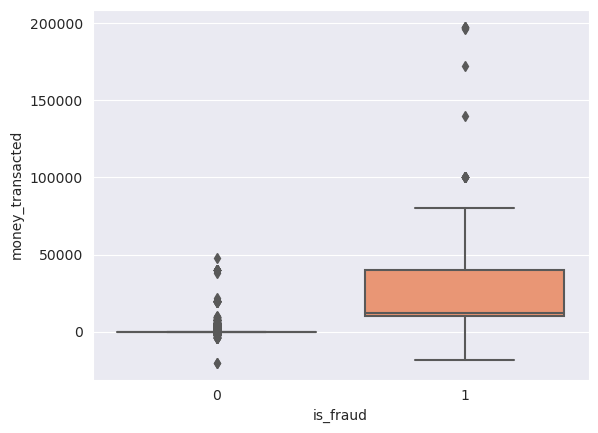

In [25]:
sns.boxplot(data=data,y="money_transacted",x="is_fraud")

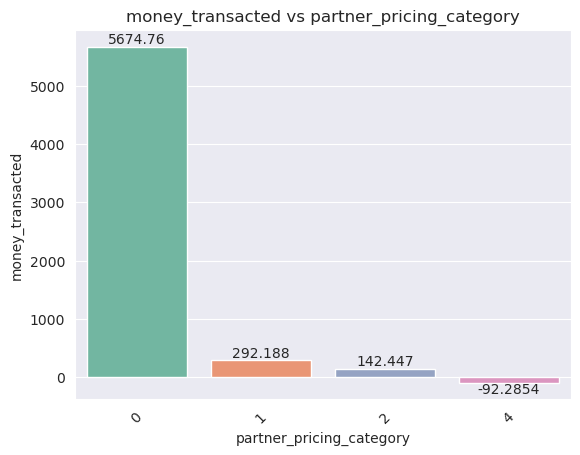

In [26]:
ax = sns.barplot(data=data_viz,y="money_transacted",x="partner_pricing_category",errorbar=None)
plt.xticks( rotation=45)
plt.title("money_transacted vs partner_pricing_category")
ax.bar_label(ax.containers[0])
plt.show()

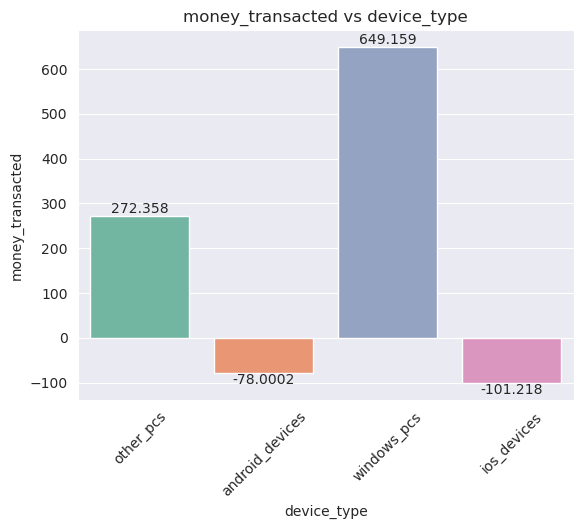

In [27]:
ax = sns.barplot(data=data_viz,y="money_transacted",x="device_type",errorbar=None)
plt.xticks( rotation=45)
plt.title("money_transacted vs device_type")
ax.bar_label(ax.containers[0])
plt.show()

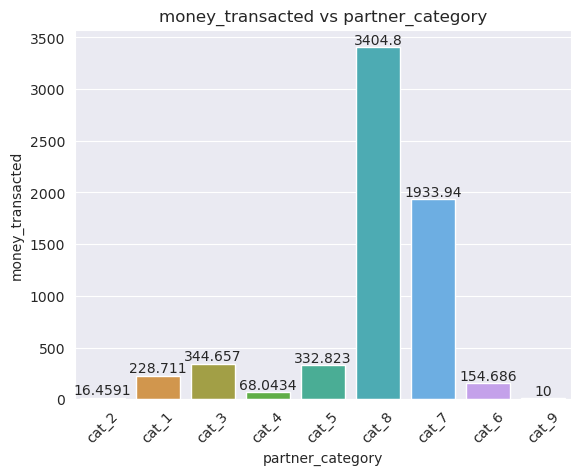

In [28]:
ax = sns.barplot(data=data_viz,y="money_transacted",x="partner_category",errorbar=None)
plt.xticks( rotation=45)
plt.title("money_transacted vs partner_category")
ax.bar_label(ax.containers[0])
plt.show()

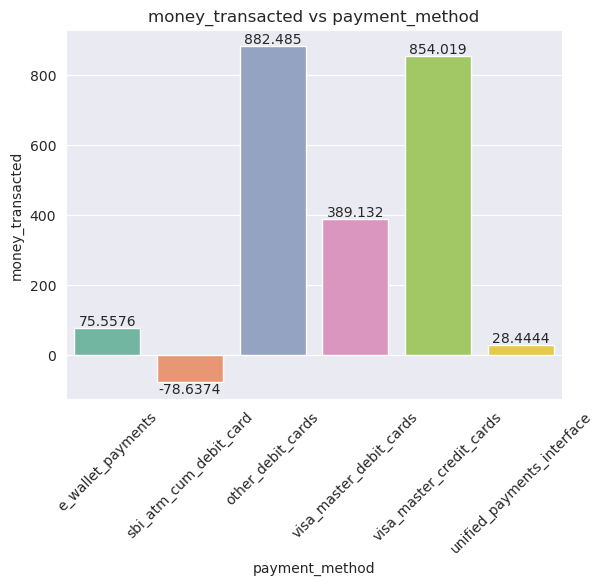

In [29]:
ax = sns.barplot(data=data_viz,y="money_transacted",x="payment_method",errorbar=None)
plt.xticks( rotation=45)
plt.title("money_transacted vs payment_method")
ax.bar_label(ax.containers[0])
plt.show()

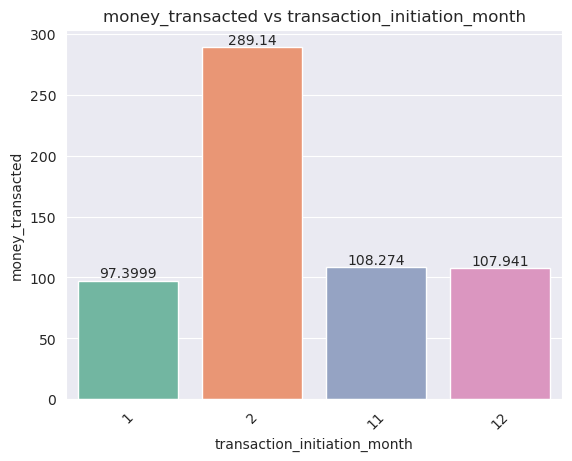

In [30]:
ax = sns.barplot(data=data_viz,y="money_transacted",x="transaction_initiation_month",errorbar=None)
plt.xticks( rotation=45)
plt.title("money_transacted vs transaction_initiation_month")
ax.bar_label(ax.containers[0])
plt.show()

---

## One hot encoding

In [31]:
cols = ['payment_method','partner_category','device_type','partner_pricing_category','transaction_initiation_month','transaction_initiation_year','transaction_initiation_day',
          'transaction_initiation_hour','transaction_initiation_minute','transaction_initiation_second']
data = pd.get_dummies(data = data, columns=cols,prefix=cols,drop_first=True)

/tmp/ipykernel_10473/3320875212.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data = pd.get_dummies(data = data, columns=cols,prefix=cols,drop_first=True)


---

## Dropping columns

In [32]:
data.drop(['country','transaction_number', 'user_id', 'partner_id',"transaction_initiation","split"],axis=1,inplace=True)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 37 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   money_transacted                           95662 non-null  float64
 1   is_fraud                                   95662 non-null  int64  
 2   payment_method_other_debit_cards           95662 non-null  uint8  
 3   payment_method_sbi_atm_cum_debit_card      95662 non-null  uint8  
 4   payment_method_unified_payments_interface  95662 non-null  uint8  
 5   payment_method_visa_master_credit_cards    95662 non-null  uint8  
 6   payment_method_visa_master_debit_cards     95662 non-null  uint8  
 7   partner_category_cat_2                     95662 non-null  uint8  
 8   partner_category_cat_3                     95662 non-null  uint8  
 9   partner_category_cat_4                     95662 non-null  uint8  
 10  partner_category_cat_5

In [34]:
uint8_cols = data.select_dtypes(include=["uint8"]).columns

In [35]:
for i in range(len(uint8_cols)):
    data[uint8_cols[i]] = data[uint8_cols[i]].astype('int64')

In [36]:
old_data = data.copy()

---

## Checking VIF to drop correlated columns

In [37]:
def calc_vif(X):
  vif = pd.DataFrame()
  vif["var"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
  vif.sort_values(by=['VIF'],ascending=False,inplace=True)
  return vif

In [38]:
X = data.drop('is_fraud',axis=1)
calc_vif(X)

/home/nox/miniconda3/envs/prog/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,var,VIF
2,payment_method_sbi_atm_cum_debit_card,inf
23,transaction_initiation_year_2017,inf
22,transaction_initiation_month_12,inf
21,transaction_initiation_month_11,inf
16,device_type_windows_pcs,inf
15,device_type_other_pcs,inf
19,partner_pricing_category_4,38.686371
18,partner_pricing_category_2,36.491284
6,partner_category_cat_2,19.747222
5,payment_method_visa_master_debit_cards,10.096090


In [39]:
X = data.drop(['is_fraud','payment_method_sbi_atm_cum_debit_card','transaction_initiation_year_2017','device_type_other_pcs','partner_pricing_category_2'],axis=1)
calc_vif(X)

,var,VIF
24,"transaction_initiation_hour_(12, 18]",2.865015
23,"transaction_initiation_hour_(6, 12]",2.757106
15,partner_pricing_category_1,2.643132
3,payment_method_visa_master_credit_cards,2.631992
22,"transaction_initiation_day_(21, 31]",2.611443
5,partner_category_cat_2,2.562426
21,"transaction_initiation_day_(14, 21]",2.139023
16,partner_pricing_category_4,2.067255
19,transaction_initiation_month_12,1.932371
20,"transaction_initiation_day_(7, 14]",1.820599


In [40]:
data.drop(['payment_method_sbi_atm_cum_debit_card','transaction_initiation_year_2017','device_type_other_pcs','partner_pricing_category_2'],axis=True,inplace=True)

---

# Model Building

In [41]:
df = data.sample(frac = 1)

X = df.drop('is_fraud', axis=1)
y = df['is_fraud']


In [42]:
train = data.iloc[train_index]
test = data.iloc[test_index]

In [43]:

X_train = train.drop('is_fraud',axis=1)
X_test = test.drop('is_fraud',axis=1)
y_train = train.is_fraud
y_test = test.is_fraud

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(76529, 32)
(19133, 32)
(76529,)
(19133,)


In [44]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76529 entries, 0 to 95661
Data columns (total 32 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   money_transacted                           76529 non-null  float64
 1   payment_method_other_debit_cards           76529 non-null  int64  
 2   payment_method_unified_payments_interface  76529 non-null  int64  
 3   payment_method_visa_master_credit_cards    76529 non-null  int64  
 4   payment_method_visa_master_debit_cards     76529 non-null  int64  
 5   partner_category_cat_2                     76529 non-null  int64  
 6   partner_category_cat_3                     76529 non-null  int64  
 7   partner_category_cat_4                     76529 non-null  int64  
 8   partner_category_cat_5                     76529 non-null  int64  
 9   partner_category_cat_6                     76529 non-null  int64  
 10  partner_category_cat_7

In [45]:
# scaling

scaler = StandardScaler()

cols = ['money_transacted']

X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols]=scaler.transform(X_test[cols])

-----------------


# Logistic Regression

In [46]:
logistic_model = LogisticRegression(max_iter=600)

logistic_model.fit(X_train,y_train)

LogisticRegression(max_iter=600)

In [47]:
train_preds = logistic_model.predict(X_train)
test_preds = logistic_model.predict(X_test)

In [48]:
confusion_matrix(y_train,train_preds)

array([[76349,    26],
       [  105,    49]])

In [49]:
train_accuracy_lr= accuracy_score(y_train,train_preds)
train_recall_lr= recall_score(y_train,train_preds)
train_precision_lr= precision_score(y_train,train_preds)
train_f1_lr = f1_score(y_train,train_preds)

test_accuracy_lr= accuracy_score(y_test,test_preds)
test_recall_lr= recall_score(y_test,test_preds)
test_precision_lr= precision_score(y_test,test_preds)
test_f1_lr = f1_score(y_test,test_preds)


In [50]:
model_performance = pd.DataFrame(np.array(['Logistic',train_accuracy_lr,train_recall_lr,train_precision_lr,train_f1_lr,
                                           test_accuracy_lr,test_recall_lr,test_precision_lr,test_f1_lr]).reshape(1,9))

model_performance.columns = ['Model','Train Accuracy','Train Recall','Train Precision','Train F1 Score',
                             'Test Accuracy','Test Recall','Test Precision','Test F1 Score']

In [51]:
model_performance

,Model,Train Accuracy,Train Recall,Train Precision,Train F1 Score,Test Accuracy,Test Recall,Test Precision,Test F1 Score
0,Logistic,0.9982882306053914,0.3181818181818182,0.6533333333333333,0.42794759825327516,0.9982752312758062,0.3333333333333333,0.65,0.4406779661016949


---

# Naive Bayes

In [52]:
# Build a Gaussian Classifier
nb_model = GaussianNB()

# nb_model training
nb_model.fit(X_train, y_train)

GaussianNB()

In [53]:
train_preds = nb_model.predict(X_train)
test_preds = nb_model.predict(X_test)

In [54]:
confusion_matrix(y_train,train_preds)

array([[ 3438, 72937],
       [    0,   154]])

In [55]:
train_accuracy_1= accuracy_score(y_train,train_preds)
train_recall_1= recall_score(y_train,train_preds)
train_precision_1= precision_score(y_train,train_preds)
train_f1 = f1_score(y_train,train_preds)

test_accuracy_1= accuracy_score(y_test,test_preds)
test_recall_1= recall_score(y_test,test_preds)
test_precision_1= precision_score(y_test,test_preds)
test_f1 = f1_score(y_test,test_preds)


In [56]:
d= np.array(['Naive Bayes',train_accuracy_1,train_recall_1,train_precision_1,train_f1,
                                           test_accuracy_1,test_recall_1,test_precision_1,test_f1]).reshape(1,9)
d=pd.DataFrame(d,columns=model_performance.columns)
model_performance = pd.concat([model_performance,d],ignore_index=True)

In [57]:
model_performance

,Model,Train Accuracy,Train Recall,Train Precision,Train F1 Score,Test Accuracy,Test Recall,Test Precision,Test F1 Score
0,Logistic,0.9982882306053914,0.3181818181818182,0.6533333333333333,0.42794759825327516,0.9982752312758062,0.3333333333333333,0.65,0.4406779661016949
1,Naive Bayes,0.04693645546132839,1.0,0.002106962553529162,0.004205065192163287,0.04338054669941985,1.0,0.0021262675825973174,0.004243512322506937


---

# KNN Model

In [58]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [59]:
train_preds = knn.predict(X_train)
test_preds = knn.predict(X_test)

In [60]:
train_accuracy_1= accuracy_score(y_train,train_preds)
train_recall_1= recall_score(y_train,train_preds)
train_precision_1= precision_score(y_train,train_preds)
train_f1 = f1_score(y_train,train_preds)

test_accuracy_1= accuracy_score(y_test,test_preds)
test_recall_1= recall_score(y_test,test_preds)
test_precision_1= precision_score(y_test,test_preds)
test_f1 = f1_score(y_test,test_preds)


In [61]:
d= np.array(['KNN',train_accuracy_1,train_recall_1,train_precision_1,train_f1,
                                           test_accuracy_1,test_recall_1,test_precision_1,test_f1]).reshape(1,9)
d=pd.DataFrame(d,columns=model_performance.columns)
model_performance = pd.concat([model_performance,d],ignore_index=True)

In [62]:
model_performance

,Model,Train Accuracy,Train Recall,Train Precision,Train F1 Score,Test Accuracy,Test Recall,Test Precision,Test F1 Score
0,Logistic,0.9982882306053914,0.3181818181818182,0.6533333333333333,0.42794759825327516,0.9982752312758062,0.3333333333333333,0.65,0.4406779661016949
1,Naive Bayes,0.04693645546132839,1.0,0.002106962553529162,0.004205065192163287,0.04338054669941985,1.0,0.0021262675825973174,0.004243512322506937
2,KNN,0.9996863933933542,0.8766233766233766,0.9642857142857143,0.9183673469387756,0.9989546856217008,0.6923076923076923,0.7714285714285715,0.7297297297297296


---

# Decision Tree Classifier

In [63]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train,y_train)


DecisionTreeClassifier(random_state=42)

In [64]:
train_preds = dt.predict(X_train)
test_preds = dt.predict(X_test)

In [65]:
train_accuracy_1= accuracy_score(y_train,train_preds)
train_recall_1= recall_score(y_train,train_preds)
train_precision_1= precision_score(y_train,train_preds)
train_f1 = f1_score(y_train,train_preds)

test_accuracy_1= accuracy_score(y_test,test_preds)
test_recall_1= recall_score(y_test,test_preds)
test_precision_1= precision_score(y_test,test_preds)
test_f1 = f1_score(y_test,test_preds)


In [66]:
d= np.array(['Decision Tree',train_accuracy_1,train_recall_1,train_precision_1,train_f1,
                                           test_accuracy_1,test_recall_1,test_precision_1,test_f1]).reshape(1,9)
d=pd.DataFrame(d,columns=model_performance.columns)
model_performance = pd.concat([model_performance,d],ignore_index=True)

In [67]:
model_performance

,Model,Train Accuracy,Train Recall,Train Precision,Train F1 Score,Test Accuracy,Test Recall,Test Precision,Test F1 Score
0,Logistic,0.9982882306053914,0.3181818181818182,0.6533333333333333,0.42794759825327516,0.9982752312758062,0.3333333333333333,0.65,0.4406779661016949
1,Naive Bayes,0.04693645546132839,1.0,0.002106962553529162,0.004205065192163287,0.04338054669941985,1.0,0.0021262675825973174,0.004243512322506937
2,KNN,0.9996863933933542,0.8766233766233766,0.9642857142857143,0.9183673469387756,0.9989546856217008,0.6923076923076923,0.7714285714285715,0.7297297297297296
3,Decision Tree,0.9999869330580564,0.9935064935064936,1.0,0.9967426710097721,0.9991637484973606,0.7692307692307693,0.8108108108108109,0.7894736842105263


In [68]:

param_grid = {'max_depth':range(1, dt.tree_.max_depth+1),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

In [69]:
train_preds = GR.predict(X_train)
test_preds = GR.predict(X_test)

In [70]:
train_accuracy_1= accuracy_score(y_train,train_preds)
train_recall_1= recall_score(y_train,train_preds)
train_precision_1= precision_score(y_train,train_preds)
train_f1 = f1_score(y_train,train_preds)

test_accuracy_1= accuracy_score(y_test,test_preds)
test_recall_1= recall_score(y_test,test_preds)
test_precision_1= precision_score(y_test,test_preds)
test_f1 = f1_score(y_test,test_preds)


In [71]:
d= np.array(['Decision Tree with GridSearchCV',train_accuracy_1,train_recall_1,train_precision_1,train_f1,
                                           test_accuracy_1,test_recall_1,test_precision_1,test_f1]).reshape(1,9)
d=pd.DataFrame(d,columns=model_performance.columns)
model_performance = pd.concat([model_performance,d],ignore_index=True)

In [72]:
model_performance

,Model,Train Accuracy,Train Recall,Train Precision,Train F1 Score,Test Accuracy,Test Recall,Test Precision,Test F1 Score
0,Logistic,0.9982882306053914,0.3181818181818182,0.6533333333333333,0.42794759825327516,0.9982752312758062,0.3333333333333333,0.65,0.4406779661016949
1,Naive Bayes,0.04693645546132839,1.0,0.002106962553529162,0.004205065192163287,0.04338054669941985,1.0,0.0021262675825973174,0.004243512322506937
2,KNN,0.9996863933933542,0.8766233766233766,0.9642857142857143,0.9183673469387756,0.9989546856217008,0.6923076923076923,0.7714285714285715,0.7297297297297296
3,Decision Tree,0.9999869330580564,0.9935064935064936,1.0,0.9967426710097721,0.9991637484973606,0.7692307692307693,0.8108108108108109,0.7894736842105263
4,Decision Tree with GridSearchCV,0.9993597198447647,0.7337662337662337,0.9338842975206612,0.8218181818181818,0.9993205456541054,0.717948717948718,0.9333333333333333,0.8115942028985509


---

# Random Forest

In [73]:
RF = RandomForestClassifier(random_state=42,n_estimators=100,n_jobs=-1)
RF = RF.fit(X_train, y_train)

In [74]:
threshold = 0.35

train_preds = RF.predict_proba(X_train)
test_preds = RF.predict_proba(X_test)

train_preds = (train_preds[:,1] >= threshold).astype('int')
test_preds = (test_preds[:,1] >= threshold).astype('int')


In [75]:
train_accuracy_1= accuracy_score(y_train,train_preds)
train_recall_1= recall_score(y_train,train_preds)
train_precision_1= precision_score(y_train,train_preds)
train_f1 = f1_score(y_train,train_preds)

test_accuracy_1= accuracy_score(y_test,test_preds)
test_recall_1= recall_score(y_test,test_preds)
test_precision_1= precision_score(y_test,test_preds)
test_f1 = f1_score(y_test,test_preds)


In [76]:
d= np.array(['Random Forest',train_accuracy_1,train_recall_1,train_precision_1,train_f1,
                                           test_accuracy_1,test_recall_1,test_precision_1,test_f1]).reshape(1,9)
d=pd.DataFrame(d,columns=model_performance.columns)
model_performance = pd.concat([model_performance,d],ignore_index=True)

In [77]:
model_performance

,Model,Train Accuracy,Train Recall,Train Precision,Train F1 Score,Test Accuracy,Test Recall,Test Precision,Test F1 Score
0,Logistic,0.9982882306053914,0.3181818181818182,0.6533333333333333,0.42794759825327516,0.9982752312758062,0.3333333333333333,0.65,0.4406779661016949
1,Naive Bayes,0.04693645546132839,1.0,0.002106962553529162,0.004205065192163287,0.04338054669941985,1.0,0.0021262675825973174,0.004243512322506937
2,KNN,0.9996863933933542,0.8766233766233766,0.9642857142857143,0.9183673469387756,0.9989546856217008,0.6923076923076923,0.7714285714285715,0.7297297297297296
3,Decision Tree,0.9999869330580564,0.9935064935064936,1.0,0.9967426710097721,0.9991637484973606,0.7692307692307693,0.8108108108108109,0.7894736842105263
4,Decision Tree with GridSearchCV,0.9993597198447647,0.7337662337662337,0.9338842975206612,0.8218181818181818,0.9993205456541054,0.717948717948718,0.9333333333333333,0.8115942028985509
5,Random Forest,0.9999869330580564,1.0,0.9935483870967742,0.9967637540453074,0.9993728113730205,0.8717948717948718,0.8292682926829268,0.8500000000000001


---

# SVM

In [78]:

rbfSVC = SVC(kernel='rbf',C=0.8)

rbfSVC = rbfSVC.fit(X_train,y_train)


In [79]:
train_preds = rbfSVC.predict(X_train)
test_preds = rbfSVC.predict(X_test)

In [80]:
train_accuracy_1= accuracy_score(y_train,train_preds)
train_recall_1= recall_score(y_train,train_preds)
train_precision_1= precision_score(y_train,train_preds)
train_f1 = f1_score(y_train,train_preds)

test_accuracy_1= accuracy_score(y_test,test_preds)
test_recall_1= recall_score(y_test,test_preds)
test_precision_1= precision_score(y_test,test_preds)
test_f1 = f1_score(y_test,test_preds)


In [81]:
d= np.array(['SVM',train_accuracy_1,train_recall_1,train_precision_1,train_f1,
                                           test_accuracy_1,test_recall_1,test_precision_1,test_f1]).reshape(1,9)
d=pd.DataFrame(d,columns=model_performance.columns)
model_performance = pd.concat([model_performance,d],ignore_index=True)

In [82]:
model_performance

,Model,Train Accuracy,Train Recall,Train Precision,Train F1 Score,Test Accuracy,Test Recall,Test Precision,Test F1 Score
0,Logistic,0.9982882306053914,0.3181818181818182,0.6533333333333333,0.42794759825327516,0.9982752312758062,0.3333333333333333,0.65,0.4406779661016949
1,Naive Bayes,0.04693645546132839,1.0,0.002106962553529162,0.004205065192163287,0.04338054669941985,1.0,0.0021262675825973174,0.004243512322506937
2,KNN,0.9996863933933542,0.8766233766233766,0.9642857142857143,0.9183673469387756,0.9989546856217008,0.6923076923076923,0.7714285714285715,0.7297297297297296
3,Decision Tree,0.9999869330580564,0.9935064935064936,1.0,0.9967426710097721,0.9991637484973606,0.7692307692307693,0.8108108108108109,0.7894736842105263
4,Decision Tree with GridSearchCV,0.9993597198447647,0.7337662337662337,0.9338842975206612,0.8218181818181818,0.9993205456541054,0.717948717948718,0.9333333333333333,0.8115942028985509
5,Random Forest,0.9999869330580564,1.0,0.9935483870967742,0.9967637540453074,0.9993728113730205,0.8717948717948718,0.8292682926829268,0.8500000000000001
6,SVM,0.999660259509467,0.8506493506493507,0.9776119402985075,0.9097222222222223,0.9992160142162756,0.6923076923076923,0.9,0.7826086956521738


---